# Problem Set #2: Drift-diffusion Model
**DUE 5 April 2022 - NEU 502A**

**Submission Directions:** Prior to submitting, clear you kernel and run through all your cells in order so figures and variables are accurately recorded. Only include cells with necessary code or answers, do not include cells used for troubleshooting. Email this notebook with your last name in the filename to Eric (ewh3@princeton.edu) by 5pm.

As mentioned in class, the drift-diffusion model has been a dominant model in understanding how decisions are made. The model predicts how one makes a decision by integrating evidence over time. Part of the power of the drift-diffusion model is how simple it is. The dynamics are captured by:
$$ dC = v \cdot dt + w \cdot \mathcal{N}(0,1) $$
Where $C$ is your decision variable, $v$ is the evidence that one is accumulating (the ‘drift’), and $w$ is the amount of noise in the integration (the ‘diffusion’). The initial condition is typically set to $C_0$ = 0 and the integration occurs to some bound +/- $B$, which initiates the choice. To get a better intuition for how the model works, let’s simulate a decision process using the drift-diffusion model.

In [311]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st

%matplotlib inline
sns.set_context('talk')

In [17]:
c = 0 #decision variable
v = 2.5 # evidence
dt = .0005 #time step 
w = 0.05 # noise weight
B = 1 # bound

**1. Simulate a simple decision process using the drift-diffusion model.** Parameters should be $C_0$ = 0, $B$ = 1, $dt$ = 0.0005 sec, $v$ = 2.5, and $w$ = 0.05. Run at least 1000 simulations to get a good sense of how the model behaves.

In [123]:
def dynamics(c, v, dt, w, B):
    '''
    To simultate the drift diffusion-to-bound model:

    INPUTS
    .  c: scalar, descision variable
    .  v: scalar, drift rate
    . dt: scalar, time step (in seconds)
    .  w: scalar, drift noise
    .  B: scalar, boundary
      
    OUTPUTS
    . c: int, decision [lb = -1, ub = 1]
    . z: scalar, reaction time (in sec)
    . x: array, accumlated evidence 
    '''
    
    C = []
    while np.abs(c) < B:                     #while the decision variable is within the decision boundary 
        c = c + v*dt + w*np.random.randn()   #update C, given the provided equation
        C.append(c)
        
    return np.array(C), np.sign(c)

1a ::: Plot a few (~10) model runs for both ‘correct’ and ‘incorrect’ trials. Briefly explain why the model occasionally makes decision errors.

In [124]:
seed=0
colors = [plt.cm.Dark2(x) for x in range(10) ]
n_sims = 1000
np.random.seed(seed) #use random.seed to keep values consistent



sim_data = []

for _ in range(n_sims):
    simulation_i = dynamics(c, v, dt, w, B)
    sim_data.append(simulation_i)
    
decisions = [sim_data_i[1] for sim_data_i in sim_data]
decisions_drift = [sim_data_i[0] for sim_data_i in sim_data]

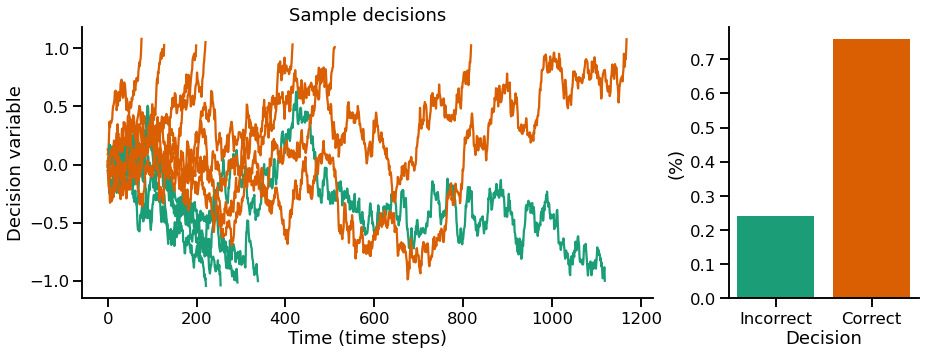

In [288]:
fig, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios': [3, 1]})

for decision_drift, decision in zip(decisions_drift[:13], decisions[:13]):
    axes[0].plot(decision_drift, color = colors[int(decision>0)])

axes[0].set_title('Sample decisions')
axes[0].set_xlabel('Time (time steps)')
axes[0].set_ylabel('Decision variable')

axes[1].bar(['Incorrect','Correct'], [np.sum(np.array(decisions)==-1)/n_sims, 
                     np.sum(np.array(decisions)==1)/n_sims], color=colors[:2])
axes[1].set_xlabel('Decision')
axes[1].set_ylabel('(%)')

sns.despine()
plt.show()

> **Answer:** TEXT HERE

1b ::: Plot the percentage of runs that ended in ‘correct’ and ‘incorrect’ choices.

In [ ]:
#see above

1c ::: Plot the reaction time distribution for ‘correct’ and ‘incorrect’ trials separately. Describe the shape of the reaction time distribution (e.g. what is the mean? the median? Is it symmetric or skewed?). Relate the shape of the reaction time distribution to human/animal behavioral responses.

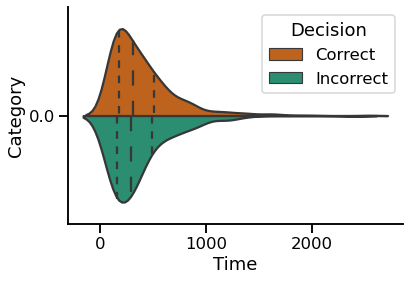

In [287]:
df = pd.DataFrame(np.vstack([decisions, decision_time, np.zeros_like(decisions)]).T, columns=('Decision','Time','Category'))

df.Decision = df.Decision.replace({-1:'Incorrect', 1:'Correct'})

g = sns.violinplot(data=df, x='Time', y='Category', orient="h",
                    hue ='Decision',   split=True, inner="quart",
                  palette= {'Incorrect': colors[0], 'Correct': colors[1]})


sns.despine()   
plt.show(g)


In [218]:
df.groupby('Decision')['Time'].agg(['count','mean','median','min', 'max']) 

,count,mean,median,min,max
Decision,,,,,
Correct,758,391.013193,308.0,28.0,2551.0
Incorrect,242,371.128099,286.5,39.0,2410.0


>**Answer:** TEXT HERE

**2. If sensory evidence is increased (2x) or decreased (0.5x), how does this impact the decision process in the drift-diffusion model?**

2a ::: Describe how you modeled a change in the sensory evidence.

> **Answer:** TEXT HERE

2b ::: As for 1a, plot a few model runs, the percent of correct/incorrect, and the reaction time distributions for all three levels of sensory evidence (baseline, increased, and decreased).

In [293]:
seed=0
np.random.seed(seed) #use random.seed to keep values consistent

v_strong = v*2
v_weak = v/2

v_conditions = [v_weak, v, v_strong]
all_decisions_v = []
all_decisions_drifts_v = []

all_conditions_v = []
all_decisions_times_v = []

for v_cond, condition in zip(v_conditions, ['weak', 'baseline', 'strong']):
    for _ in range(n_sims):
        simulation_i = dynamics(c, v_cond, dt, w, B)
        all_decisions_v.append(simulation_i[1])
        all_conditions_v.append(condition)
        all_decisions_times_v.append(len(simulation_i[0]))
        all_decisions_drifts_v.append(simulation_i[0])

In [294]:
df_all_v = pd.DataFrame(np.vstack([all_decisions_drifts_v, all_decisions_v, 
                                   all_decisions_times_v, 
                                 np.zeros_like(all_decisions_v), all_conditions_v]).T, 
                      columns=('Drift','Decision','Time','Category', 'Condition'))


In [295]:
df_all_v.head()

,Drift,Decision,Time,Category,Condition
0,"[0.0888276172983832, 0.10946047771674437, 0.15...",1,130,0,weak
1,"[-0.037870803722265825, -0.01028334415767496, ...",-1,227,0,weak
2,"[-0.023273700202024336, -0.04663149090242172, ...",-1,233,0,weak
3,"[0.027790594569375986, 0.05036774245297811, 0....",-1,188,0,weak
4,"[-0.08099616510339917, -0.08372787283412526, -...",1,341,0,weak


In [298]:
weak_data = df_all_v[(df_all_v.Condition=='weak')]
strong_data = df_all_v[(df_all_v.Condition=='strong')]
baseline_data = df_all_v[(df_all_v.Condition=='baseline')]

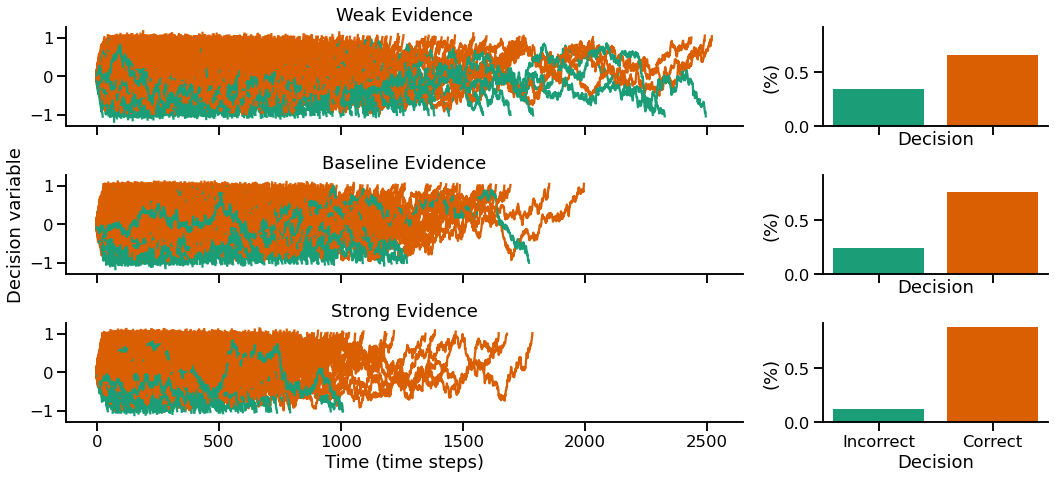

In [310]:
fig, axes = plt.subplots(3,2, figsize=(15,7), sharex='col', sharey='col',
                         gridspec_kw={'width_ratios': [3, 1]})

axes[0][0].set_title('Weak Evidence')
axes[1][0].set_title('Baseline Evidence')
axes[2][0].set_title('Strong Evidence')


for d in weak_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[0][0].plot(d_drift, color = colors[int(d_decision>0)])

# axes[0][0].set_xlabel('Time (time steps)')
# axes[0][0].set_ylabel('Decision variable')


axes[0][1].bar(['Incorrect','Correct'], [np.sum(np.array(weak_data.Decision)==-1)/n_sims, 
                     np.sum(np.array(weak_data.Decision)==1)/n_sims], color=colors[:2])
axes[0][1].set_xlabel('Decision')
axes[0][1].set_ylabel('(%)')


for d in baseline_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[1][0].plot(d_drift, color = colors[int(d_decision>0)])

#axes[1][0].set_xlabel('Time (time steps)')
axes[1][0].set_ylabel('Decision variable')


axes[1][1].bar(['Incorrect','Correct'], [np.sum(np.array(baseline_data.Decision)==-1)/n_sims, 
                     np.sum(np.array(baseline_data.Decision)==1)/n_sims], color=colors[:2])
axes[1][1].set_xlabel('Decision')
axes[1][1].set_ylabel('(%)')

for d in strong_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[2][0].plot(d_drift, color = colors[int(d_decision>0)])

axes[2][0].set_xlabel('Time (time steps)')
#axes[2][0].set_ylabel('Decision variable')


axes[2][1].bar(['Incorrect','Correct'], [np.sum(np.array(strong_data.Decision)==-1)/n_sims, 
                     np.sum(np.array(strong_data.Decision)==1)/n_sims], color=colors[:2])
axes[2][1].set_xlabel('Decision')
axes[2][1].set_ylabel('(%)')

sns.despine()
plt.tight_layout()
plt.show()

**3. Subjects appear to be able to trade accuracy for speed in most perceptual decision making tasks. The drift-diffusion model can capture this tradeoff in a simple manner.**

3a ::: Describe how you modeled the accuracy/speed tradeoff. Why is this a biologically plausible way of capturing this effect?

> **Answer:** TEXT HERE

3b ::: Again, as in 1a, plot a few model runs, the percent of correct/incorrect, and the reaction time distributions for your baseline model, an ‘accurate’ biased model, and a ‘speed’ biased model.

In [291]:
np.random.seed(seed)# use random.seed to keep values consistent


b_speed = B -.5
b_accurate = B +.5

b_conditions = [b_speed, B, b_accurate]
all_decisions_b = []
all_decisions_drifts_b = []

all_conditions_b = []
all_decisions_times_b = []

for b_cond, condition in zip(b_conditions, ['speed', 'baseline', 'accurate']):
    for _ in range(n_sims):
        simulation_i = dynamics(c, v, dt, w, b_cond)
        all_decisions_b.append(simulation_i[1])
        all_conditions_b.append(condition)
        all_decisions_times_b.append(len(simulation_i[0]))
        all_decisions_drifts_b.append(simulation_i[0])

In [301]:
df_all_b = pd.DataFrame(np.vstack([all_decisions_drifts_b, all_decisions_b, all_decisions_times_b, 
                                 np.zeros_like(all_decisions_b), all_conditions_b]).T, 
                      columns=('Drift','Decision','Time','Category', 'Condition'))


In [302]:
speed_data = df_all_b[(df_all_b.Condition=='speed')]
accurate_data = df_all_b[(df_all_b.Condition=='accurate')]
baseline_data = df_all_b[(df_all_b.Condition=='baseline')]

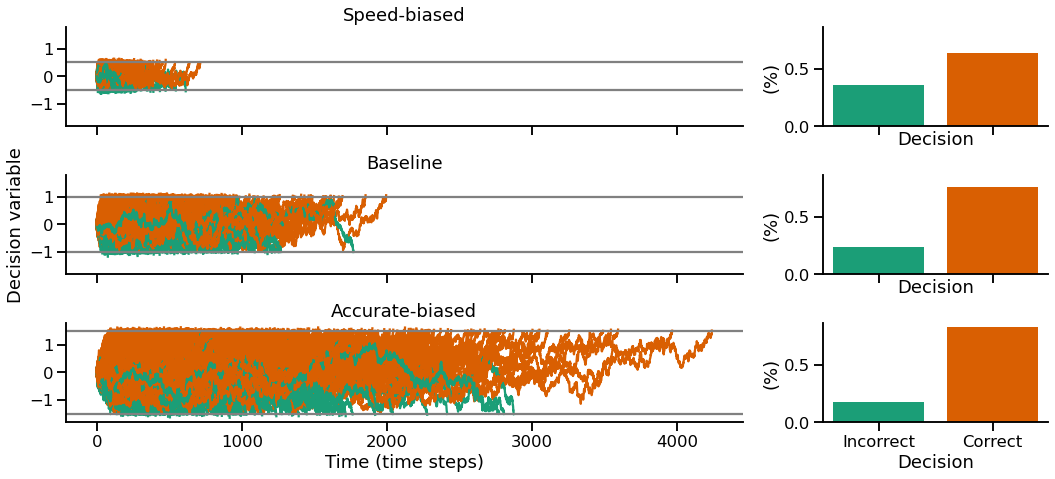

In [309]:
fig, axes = plt.subplots(3,2, figsize=(15,7), sharex='col', sharey='col',
                         gridspec_kw={'width_ratios': [3, 1]})

axes[0][0].set_title('Speed-biased')
axes[1][0].set_title('Baseline')
axes[2][0].set_title('Accurate-biased')


for d in speed_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[0][0].plot(d_drift, color = colors[int(d_decision>0)])

# axes[0][0].set_xlabel('Time (time steps)')
# axes[0][0].set_ylabel('Decision variable')

axes[0][0].axhline(y=.5, color='grey')
axes[0][0].axhline(y=-.5, color='grey')

axes[0][1].bar(['Incorrect','Correct'], [np.sum(np.array(speed_data.Decision)==-1)/n_sims, 
                     np.sum(np.array(speed_data.Decision)==1)/n_sims], color=colors[:2])
axes[0][1].set_xlabel('Decision')
axes[0][1].set_ylabel('(%)')


for d in baseline_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[1][0].plot(d_drift, color = colors[int(d_decision>0)])

#axes[1][0].set_xlabel('Time (time steps)')
axes[1][0].set_ylabel('Decision variable')
axes[1][0].axhline(y=1, color='grey')
axes[1][0].axhline(y=-1, color='grey')

axes[1][1].bar(['Incorrect','Correct'], [np.sum(np.array(baseline_data.Decision)==-1)/n_sims, 
                     np.sum(np.array(baseline_data.Decision)==1)/n_sims], color=colors[:2])
axes[1][1].set_xlabel('Decision')
axes[1][1].set_ylabel('(%)')

for d in accurate_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[2][0].plot(d_drift, color = colors[int(d_decision>0)])

axes[2][0].set_xlabel('Time (time steps)')
#axes[2][0].set_ylabel('Decision variable')
axes[2][0].axhline(y=1.5, color='grey')
axes[2][0].axhline(y=-1.5, color='grey')

axes[2][1].bar(['Incorrect','Correct'], [np.sum(np.array(accurate_data.Decision)==-1)/n_sims, 
                     np.sum(np.array(accurate_data.Decision)==1)/n_sims], color=colors[:2])
axes[2][1].set_xlabel('Decision')
axes[2][1].set_ylabel('(%)')

sns.despine()

plt.tight_layout()
plt.show()

**4. Using the original ‘baseline’ model, if you examine the reaction time distributions for correct and error trials you’ll notice that they are overlapping. However, in experiments, reaction times for incorrect trials are typically longer than for correct trials.** To capture this effect, let’s add some more variability across trials. Instead of a fixed $v$ for all trials, allow $v$ to vary across trials according to a normal distribution: $v$ = 2.5 + $N$(0, 2.5).

4a ::: Plot the reaction time distributions for both correct and incorrect trials. Describe the distributions as in 1a. Does this better capture experimental observations?

In [314]:
#np.random.seed(###) use random.seed to keep values consistent

get_v_stochastic = lambda: 2.5 + st.norm(0, 2.5).rvs()

np.random.seed(seed)# use random.seed to keep values consistent



v2_conditions = [v, None]
all_decisions_v2 = []
all_decisions_drifts_v2 = []

all_conditions_v2 = []
all_decisions_times_v2 = []

for v_cond, condition in zip(v2_conditions, ['baseline', 'stochastic']):
    for _ in range(n_sims):
        if v_cond is None:
            v_cond = get_v_stochastic()
        simulation_i = dynamics(c, v_cond, dt, w, B)
        all_decisions_v2.append(simulation_i[1])
        all_conditions_v2.append(condition)
        all_decisions_times_v2.append(len(simulation_i[0]))
        all_decisions_drifts_v2.append(simulation_i[0])

In [315]:
df_all_v2 = pd.DataFrame(np.vstack([all_decisions_drifts_v2, all_decisions_v2, 
                                    all_decisions_times_v2, 
                                 np.zeros_like(all_decisions_v2), all_conditions_v2]).T, 
                      columns=('Drift','Decision','Time','Category', 'Condition'))


In [318]:
stochastic_data = df_all_v2[(df_all_v2.Condition=='stochastic')]
baseline_data = df_all_v2[(df_all_v2.Condition=='baseline')]

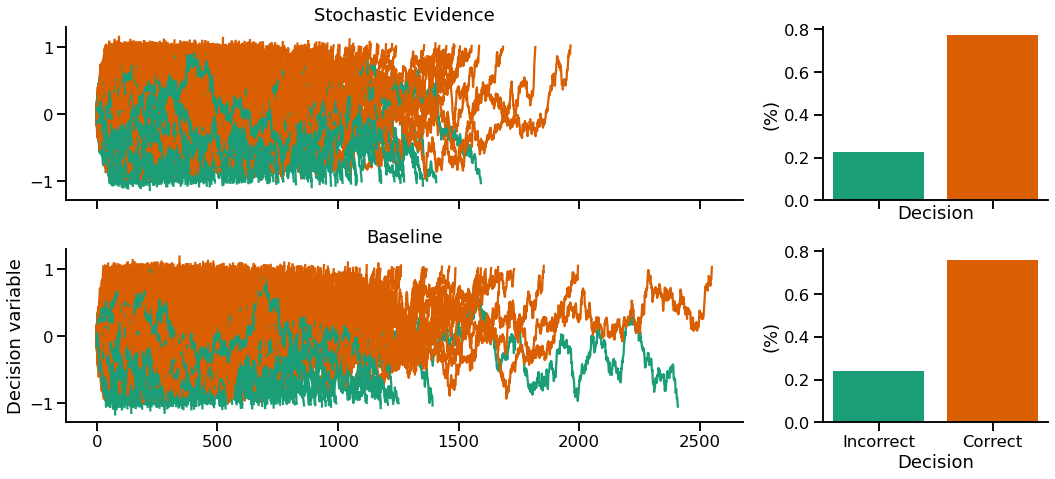

In [319]:
fig, axes = plt.subplots(2,2, figsize=(15,7), sharex='col', sharey='col',
                         gridspec_kw={'width_ratios': [3, 1]})

axes[0][0].set_title('Stochastic Evidence')
axes[1][0].set_title('Baseline')


for d in stochastic_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[0][0].plot(d_drift, color = colors[int(d_decision>0)])

# axes[0][0].set_xlabel('Time (time steps)')
# axes[0][0].set_ylabel('Decision variable')


axes[0][1].bar(['Incorrect','Correct'], [np.sum(np.array(stochastic_data.Decision)==-1)/n_sims, 
                     np.sum(np.array(stochastic_data.Decision)==1)/n_sims], color=colors[:2])
axes[0][1].set_xlabel('Decision')
axes[0][1].set_ylabel('(%)')


for d in baseline_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[1][0].plot(d_drift, color = colors[int(d_decision>0)])

#axes[1][0].set_xlabel('Time (time steps)')
axes[1][0].set_ylabel('Decision variable')


axes[1][1].bar(['Incorrect','Correct'], [np.sum(np.array(baseline_data.Decision)==-1)/n_sims, 
                     np.sum(np.array(baseline_data.Decision)==1)/n_sims], color=colors[:2])
axes[1][1].set_xlabel('Decision')
axes[1][1].set_ylabel('(%)')


sns.despine()

plt.tight_layout()
plt.show()

> **Answer:** TEXT HERE

4b ::: Provide an intuitive explanation for why there is now an increase in reaction time for error trials. Is this biologically plausible?

> **Answer:** TEXT HERE